<h1 align="center">Machine Learning</h1><h2 align="center" style="margin:10px">Assignment 2</h2>

In [ ]:
# Student names and numbers:


The assignments below should be solved and documented as a mini-project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to. The easiest way to convert to pdf is to save this notebook as .html (File-->Download as-->HTML) and then convert this html file to pdf. You can also export as pdf directly, but here you need to watch your margins as the converter will cut off your code (i.e. make vertical code!).

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For most of the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

In [1]:
# Import all necessary libraries here
import mglearn
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import scipy as scipy
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import optimizers

import tensorflow as tf
from numpy.random import seed

# Exercise 1: Sentiment analysis

In this exercise we use the IMDB-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [2]:
reviews = pd.read_csv('IMDB_dataset/reviews.txt', header=None)
labels = pd.read_csv('IMDB_dataset/labels.txt', header=None)
Y = np.array((labels=='positive').astype(np.int_)).ravel()

print(type(reviews))
print(reviews.head)

<class 'pandas.core.frame.DataFrame'>
<bound method NDFrame.head of                                                        0
0      bromwell high is a cartoon comedy . it ran at ...
1      story of a man who has unnatural feelings for ...
2      homelessness  or houselessness as george carli...
3      airport    starts as a brand new luxury    pla...
4      brilliant over  acting by lesley ann warren . ...
...                                                  ...
24995  i saw  descent  last night at the stockholm fi...
24996  a christmas together actually came before my t...
24997  some films that you pick up for a pound turn o...
24998  working  class romantic drama from director ma...
24999  this is one of the dumbest films  i  ve ever s...

[25000 rows x 1 columns]>


**a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing.


In [3]:
X_trainval, X_test, y_trainval, y_test = train_test_split(reviews, Y, random_state=42)
print("Size of training-val set:{}".format(X_trainval.shape[0]))
print("Size of test set:{}".format(X_test.shape[0]))

Size of training-val set:18750
Size of test set:6250


**b)** Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. (See an example of how to do this in chapter 7 of "Muller and Guido"). Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [5]:
vect = CountVectorizer(max_features=10000).fit(reviews[0])
print(vect.vocabulary_)

{'high': 4193, 'is': 4715, 'cartoon': 1334, 'comedy': 1735, 'it': 4728, 'ran': 7082, 'at': 549, 'the': 8945, 'same': 7663, 'time': 9053, 'as': 501, 'some': 8254, 'other': 6283, 'programs': 6897, 'about': 12, 'school': 7737, 'life': 5182, 'such': 8651, 'teachers': 8864, 'my': 5913, 'years': 9955, 'in': 4473, 'teaching': 8866, 'profession': 6886, 'lead': 5099, 'me': 5575, 'to': 9074, 'believe': 811, 'that': 8943, 'satire': 7694, 'much': 5872, 'closer': 1646, 'reality': 7156, 'than': 8938, 'survive': 8744, 'insightful': 4583, 'students': 8594, 'who': 9782, 'can': 1254, 'see': 7813, 'right': 7472, 'through': 9021, 'their': 8951, 'pathetic': 6448, 'of': 6175, 'whole': 9784, 'situation': 8123, 'all': 244, 'remind': 7304, 'schools': 7738, 'knew': 4971, 'and': 323, 'when': 9766, 'saw': 7707, 'episode': 3014, 'which': 9772, 'student': 8593, 'repeatedly': 7330, 'tried': 9231, 'burn': 1180, 'down': 2660, 'immediately': 4443, 'classic': 1597, 'line': 5222, 'inspector': 4591, 'here': 4171, 'sack': 

In [45]:

## make the initial train-val data and test data transformed as a bag-of-words representation 
X_trainval_transformed = vect.transform(X_trainval[0]).toarray()
X_test_transformed = vect.transform(X_test[0]).toarray()

In [46]:
## training a KNN algoritm on the train-val data using cross-validation
best_score = 0
best_num_neighbors = 0


for num_neighbors in range(1,15):
    # Set a certain number of neighbors
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    
    # Perform cross validation
    scores = cross_val_score(knn, X_trainval_transformed, y_trainval, cv=5)
    
    # Compute the mean score
    score = scores.mean()
    
    # If improvement, store score and parameter
    if score>best_score:
        best_score = score
        best_num_neighbors = num_neighbors
        
# Build a model on the combine training and valiation data
knn = KNeighborsClassifier(n_neighbors=best_num_neighbors)
knn.fit(X_trainval_transformed, y_trainval)

print("Best number of neighbors found: {}".format(best_num_neighbors))
print("Best average score: {}".format(best_score))
print("Score on training/validation set: {}".format(knn.score(X_trainval_transformed, y_trainval)))
print("Score on test set: {}".format(knn.score(X_test_transformed, y_test)))

#Best number of neighbors found: 14
#Best average score: 0.64432
#Score on training/validation set: 0.71968
#Score on test set: 0.65632

Best number of neighbors found: 14
Best average score: 0.64432
Score on training/validation set: 0.71968
Score on test set: 0.65632


**c)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [54]:
##Representation of a word against the dataset
print( "Number of occurences: {}".format(vect.vocabulary_["high"]))

##Representation of a review
reviewA = vect.transform([reviews[0][5]]).toarray()
print("0 represents a word that is not part of the first 10000 most freqvent words; 1 the opossite ")
print(reviewA)

Number of occurences: 4193
0 represents a word that is not part of the first 10000 most freqvent words; 1 the opossite 
[[0 0 0 ... 0 0 0]]


**d)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [57]:
## Necessary modifications such that we can use the input data for a  convolutional network

Y = to_categorical(Y,2)
X = reviews.reshape([-1, 8, 8, 1])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y)
X_train[0].shape

NameError: name 'to_categorical' is not defined

In [ ]:
# If you want reproducable results, uncomment the following 4 lines:
seed(0)
tf.random.set_seed(0)

# Now we define and train the neural network:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='tanh', input_shape=X[0].shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # The convolutional and pooling layers output a 2D array. We need 1D for the final, output layer.
model.add(Dense(units=10, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=50, verbose=1)

print("Accuracy on training data: {}".format(model.evaluate(X_train, Y_train)))

**e)** Test your sentiment-classifier on the test set.

In [ ]:
print("Accuracy on testing data: {}".format(model.evaluate(X_test, Y_test)))

**h)** Use the classifier to classify a few sentences you write yourselves. 

# Exercise 2: MNIST

In this exercise, we consider the famous MNIST dataset, which is loaded below. The dataset consists of 70000 handwritten digits 0-9 at a resolution of 28x28 pixels. In the cell below, the dataset is loaded and split into 60000 traning and 10000 testing images. 

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


The code-snippet below can be used to see the images corresponding to individual digits:

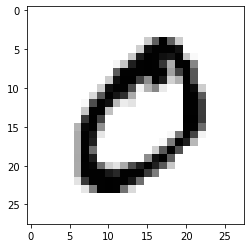

In [7]:
import matplotlib.pyplot as plt
index = 1

plt.imshow(x_train[index],cmap=plt.cm.gray_r)
plt.show()

To make things a little bit simpler (and faster!), we can extract from the data binary subsets, that only contain the data for two selected digits:

In [ ]:
import numpy as np

digit0=3
digit1=7
x_bin_train=x_train[np.logical_or(y_train==digit0,y_train==digit1)]
y_bin_train=y_train[np.logical_or(y_train==digit0,y_train==digit1)]

x_bin_test=x_test[np.logical_or(y_test==digit0,y_test==digit1)]
y_bin_test=y_test[np.logical_or(y_test==digit0,y_test==digit1)]

print("The first training datapoint now is: \n")
plt.imshow(x_bin_train[0],cmap=plt.cm.gray_r)
plt.show()
print(y_bin_train[0])

### Training a neural network

**a)** Learn different neural network models by varying the network architecture (i.e. number of layers and neurons in each layer) and the type of network (i.e. fully connected vs. convolutional). For each configuration, determine the time it takes to learn the model, and the accuracy on the test data. *Caution*: for some configurations, learning here can take a little while (several minutes).

**b)** Inspect some misclassified cases. Do they correspond to hard to recognize digits (also for the human reader)? (Hint: you can e.g. use the numpy where() function to extract the indices of the test cases that were misclassified: `misclass = np.where(test != predictions)` )

**c)** How do results (time and accuracy) change, depending on whether you consider an 'easy' binary task (e.g., distinguishing '1' and '0'), or a more difficult one (e.g., '4' vs. '5'). 

**d)** Identify one or several good configurations that give a reasonable combination of accuracy and runtime. Use these configurations to perform a full classification of the 10 classes in the original dataset (after split into train/test). Using `sklearn.metrics.confusion_matrix` you can get an overview of all combinations of true and predicted labels (see p. 298-299 in Müller & Guido). What does this tell you about which digits are easy, and which ones are difficult to recognize, and which ones are most easily confused?

### Cheating

We next investigate the capability of the neural networks to find a good model, knowing that a very accurate model exists. For this, we add some 'cheat info' to our data: we replace the first pixel value in the data matrix by a digit that simply contains a 0/1 encoding of the actual class label: 

In [ ]:
#adding cheating information to the training data:
cheatcol_train=np.array(y_bin_train) #making a copy of the original target array
cheatcol_train[cheatcol_train==digit0]=0  #re-coding the two classes as 0s and 1s
cheatcol_train[cheatcol_train==digit1]=1
x_bin_cheat_train = np.copy(x_bin_train)
x_bin_cheat_train[:,0,0] = cheatcol_train.reshape(len(cheatcol_train))

#adding cheating information to the testing data:
cheatcol_test=np.array(y_bin_test) #making a copy of the original target array
cheatcol_test[cheatcol_test==digit0]=0  #re-coding the two classes as 0s and 1s
cheatcol_test[cheatcol_test==digit1]=1
x_bin_cheat_test = np.copy(x_bin_test)
x_bin_cheat_test[:,0,0] = cheatcol_test.reshape(len(cheatcol_test))

The neural networks should, in principle, be able to construct a 100% accurate classifier for this data: we only have to 'learn' that only the first pixel in the data matters. 

**e)** Describe, briefly, how the weights of a (fully connected) network (with arbitrary number of layers) would have to be set, so that the resulting model is 100% accurate on this cheating data. This part of the exercise does not involve any Python code. Just give your answer in a short text.

**f)** Investigate how the accuracy improves in practice on this new dataset. Do you achieve 100% accuracy on the test set? If not, try to change the encoding in the cheat column: instead of representing digit1 with a 1, use a larger number, e.g. 250. Does that help? Why?

# Exercise 3 - Data preparation, exploration and feature engineering

In this exercise, you are going to investigate student dropout based on the dataset "churn2000.cvs". This is a real dataset, and there is no single "correct" way to use it (however, there are several wrong ones!). Your exercise is to explore one or more possible usecases, and document the one(s) you find the most fruitful/interesting.  Your work should probably include the steps below:

- An investigation of the data, using e.g. FACETs, Pandas, and/or whatever other tools you prefer. Can you find any interesting correlations? Are there problematic features or rows in the dataset?
- Handle missing data and possible outliers (in each case, consider what you want to do: Remove row? Remove column? Insert custom value?).
- Normalize/bin/create dummy variables where relevant. 
- Determine what you would like to predict, i.e. choose your target variable. Try formulating a specific usecase for your experiment (e.g. "Given a students perfomance in high school and first semester, what is the probability that he/she churns in the 2. semester?")
- Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?
- What features seem to be important for predicting whether a student is likely to drop out?

Warning: Make sure you carefully consider what information is available at the time where a prediction is to be made - for example, it doesn't make any sense to try to predict if a student churns in semester 1, if you include a feature which tells that this student churned in semester 2!  So depending on your specific usecase, you should probably remove some columns and/or rows before you train your model.

# Exercise 4: Reinforcement Learning

You can carry out this part of the project either in a jupyter notebook or in a google colab notebook - the latter option allows you to easily use the GPU, rather than the CPU, for training, which is MUCH faster! See these videos for how to get started with google colab notebooks: https://www.youtube.com/watch?v=inN8seMm7UI (for getting started) and https://www.youtube.com/watch?v=PitcORQSjNM (for using the GPU). At the end, you can simply merge the generated pdfs when you submit your project. 


In this final exercise, we are going to explore the concept of reinforcement learning by training a neural network to play a game of your own choice.

We will use the environments provided in OpenAI Gym https://gym.openai.com/ and also documented here: https://github.com/openai/gym/wiki

Instead of implementing Q-learning yourselves, you are welcome to simply run a pre-coded example.
You can look here for inspiration: https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb 

In the exercise, toy around with the parameters, and see if you can optimize learning. You should also explain the basics of what is going on. Include some pictures of the animation, and report your score.

a) Give a short description of the rules and incentives in the game.

b) Run the code (either directly in the notebook or on Colab), and show how the training progresses, for example by taking screenshots and including them as pictures in the notebook.

c) Give a short description of what is going on in the code. This should include a description of the neural network, the inputs and outputs to the neural network, and the process of Q-learning.

d) Report the highest score your network was able to obtain. 